# Experience Replay and DynaQ

Date: **2nd June, 2021**


Name: **Alex GMTR**


# Setup

## Imports

In [ ]:
import functools
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Gridworlds

In [ ]:
#@title Implementation
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap="YlOrRd_r")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-3):
      plt.plot([+0.5, w-1.5], [y+1.5, y+1.5], '-k', lw=2, alpha=0.5)
    for x in range(w-3):
      plt.plot([x+1.5, x+1.5], [+0.5, h-1.5], '-k', lw=2, alpha=0.5)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()
  
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return features / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

A grid world


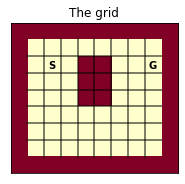


An alternative grid world


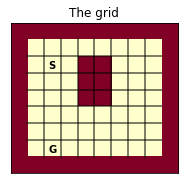


Features (visualised as 9x9 heatmaps) for different locations in the grid
(Note: includes unreachable states that coincide with walls in this visualisation.)


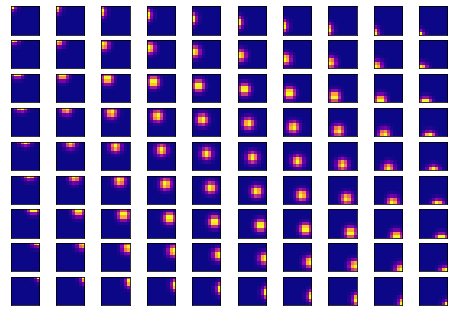

In [ ]:
#@title Show gridworlds

# Plot tabular environments
grid = Grid()
alt_grid = AltGrid()
print("A grid world")
grid.plot_grid()
plt.show()
print("\nAn alternative grid world")
alt_grid.plot_grid()
plt.show()

# Plot features of each state for non tabular version of the environment.
print(
    "\nFeatures (visualised as 9x9 heatmaps) for different locations in the grid"
    "\n(Note: includes unreachable states that coincide with walls in this visualisation.)"
)
feat_grid = FeatureGrid()
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])
for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)),
            interpolation='nearest',
            cmap='plasma')
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

## Helpers

In [ ]:
#@title helper functions

def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward
  
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def random_policy(q):
  return np.random.randint(4)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy_v2(grid, pi):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(pi, axis=2)
  grid.plot_grid()
  h, w = grid._layout.shape
  for y in range(2, h-2):
    for x in range(2, w-2):
      action_name = action_names[greedy_actions[y-2, x-2]]
      plt.text(x, y, action_name, ha='center', va='center')

# Models

### Tabular model

The model implements: 
* a *next_state* method, taking a state and action and returning the next state in the environment.
* a *reward* method, taking a state and action and returning the immediate reward associated to executing that action in that state.
* a *discount* method, taking a state and action and returning the discount associated to executing that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model predictions.

In [ ]:
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    #Initialise reward model
    self._m_r = np.zeros((number_of_states, number_of_actions))
    #next state state s', given a current state s and action a
    self._M = np.zeros((number_of_states, number_of_actions))
    #Initialise discount factor model
    self._m_g = np.zeros((number_of_states, number_of_actions))

  def next_state(self, s, a):
    return int(self._M[s, a])
  
  def reward(self, s, a):
    return self._m_r[s, a]

  def discount(self, s, a):
    return self._m_g[s, a]
  
  def transition(self, state, action):
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state):
    s = state
    a = action
    r = reward
    g = discount

    #Update the state model
    self._M[s, a] = next_state

    #Update the reward model
    self._m_r[s, a] = r

    #Update the discount factor model
    self._m_g[s, a] = g

### Linear model

The model implements: 
* a *next_state* method, taking a state and action and returning the predicted next state in the environment.
* a *reward* method, taking a state and action and returning the predicted immediate reward associated to executing that action in that state.
* a *discount* method, taking a state and action and returning the predicted discount associated to executing that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

For each selected action, the predicted reward $r'$, discount $\gamma'$ and next state $\mathbf{s}'$ will all be a linear function of the current state $\mathbf{s}$.
* $\mathbf{s}' = \mathbf{M}_a \mathbf{s}$
* $r' = (\mathbf{m}^r_a)^{\top} \mathbf{s}$
* $\gamma' = (\mathbf{m}^{\gamma}_a)^{\top} \mathbf{s}$

Where $\mathbf{M}_a$ is a matrix of shape $(\text{number_of_features}, \text{number_of_features})$, $\mathbf{m}^r_a$ and $\mathbf{m}^{\gamma}_a$ are vectors of shape $(\text{number_of_features},)$

The parameters of all these linear transformations are trained by stochastic gradient descent.

In [ ]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    #Initialise reward model
    self._m_r = np.zeros((number_of_features, number_of_actions))
    #Next state state s', given a current state s and action a
    self._M = np.zeros((number_of_features, number_of_features, number_of_actions))
    #Initialise discount factor model
    self._m_g = np.zeros((number_of_features, number_of_actions))

  def next_state(self, s, a):
    next_s = np.dot(self._M[:, :, a], s)
    return next_s
  
  def reward(self, s, a):
    r = np.dot(self._m_r[:, a], s)
    return r

  def discount(self, s, a):
    g = np.dot(self._m_g[:, a], s)
    return g

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):
    s = state
    a = action
    r = reward
    g = discount

    #Update the state transition model
    for i in range(len(s)):
        self._M[i, :, a] = self._M[i, :, a] + step_size*(next_state[i] - np.dot(self._M[i, :, a], s))*s

    #Update the reward model
    self._m_r[:, a] = self._m_r[:, a] +\
    step_size*(r - np.dot(self._m_r[:, a], s))*s

    #Update the discount factor model
    self._m_g[:, a] = self._m_g[:, a] +\
    step_size*(g - np.dot(self._m_g[:, a], s))*s

    return 

# Agents

This block implements 4 agent:
- Tabular Q-learning with Experience Replay
- Tabular Dyna-Q with a tabular model
- Linear Q-learning with Experience Replay
- Linear Dyna-Q with a linear model

All agents share the agent interface below:

#### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor provides the agent the number of actions, number of states, and the initial observation. The initial observation is obtained by instantiating an environment (e.g., `grid = Grid()`), and then calling `grid.get_obs()`.

#### `step(self, reward, discount, next_observation)`:
The step updates the internal values and returns a new action to take.
 
#### `q_values()`:
For tabular agents **only**. This method returns a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

#### `q_values(state)`:
For agents with function approximation **only**. This method returns an array of Q values of shape: (`number_of_actions`)


### Experience Replay

The agent uses Experience Replay to learn action values. At each step, the agent:
* selects actions randomly
* accumulates each observed transition *(s, a, r, g, s')* in a *replay buffer*,
* applies an online Q-learning update with the most recently observed transition,
* applies multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

The `step` function of the agent looks as follows:

1. Append most recent observed transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ 

1. Loop repeat n times:

  1. Sample $S, A, R, \gamma, S'$ from replay
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [ ]:
class ExperienceQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self._state = initial_state
    self._step_size = step_size
    self._num_offline_updates = num_offline_updates
    #select the initial action randomly
    self._action = np.random.randint(0, number_of_actions)
    
    self._replay_buff = []
    self._q_vals = np.zeros((number_of_states, number_of_actions))
    self._behaviour_policy = behaviour_policy

  @property
  def q_values(self):
    return self._q_vals

  def step(self, reward, discount, next_state):
    #Introduce a short-hand notation
    s = self._state
    a = self._action
    r = reward
    g = discount

    #Step 1: Append the most recently observed transition (𝑆𝑡,𝐴𝑡,𝑅𝑡+1,𝛾,𝑆𝑡+1) 
    #to the replay buffer
    self._replay_buff.append([s, a, r, g, next_state])

    #Step 2: Update q values with q-learning using the latest transition

    self._q_vals[s, a] = self._q_vals[s, a] + \
    self._step_size*(r + g*np.max(self._q_vals[next_state, :]) - \
                     self._q_vals[s, a])
    
    #Step 3: carry out the planning loop
    if len(self._replay_buff) > 1: #[AS: what is the minimum buffer size?]
      for i in range(self._num_offline_updates):
        #see Sutton and Barto (2020), p. 440:
        #Instead of St+1 becoming the new St for the next update as it would 
        #in the usual form of Q-learning, a new unconnected experience was drawn 
        #from the replay memory to supply data for the next update.

        rnd_idx = np.random.randint(0, len(self._replay_buff))
        
        s = self._replay_buff[rnd_idx][0]
        a = self._replay_buff[rnd_idx][1]
        r = self._replay_buff[rnd_idx][2]
        g = self._replay_buff[rnd_idx][3]
        next_s = self._replay_buff[rnd_idx][4]

        self._q_vals[s, a] = self._q_vals[s, a] + \
        self._step_size*(r + g*np.max(self._q_vals[next_s, :]) - \
                      self._q_vals[s, a])

    self._state = next_state
    next_action = self._behaviour_policy(self._q_vals)
    self._action = next_action
    
    return next_action


### Dyna-Q

The agent uses Dyna-Q to learn action values. At each step, the agent:
* selects actions randomly
* accumulates all observed transitions *(s, a)* in the environment in a *replay buffer*,
* applies an online Q-learning to Q-value
* applies an update to the *model* based on the latest transition
* applies multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

The `step` function conceptually looks as follows:
1. Append most recent observed transition $(S_t, A_t)$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Update model: $M(S_t, A_t)$, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Loop repeat n times:

  1. Sample $S, A$ from replay
  
  1. Generate $R, \gamma, S' = M(S, A)$
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [ ]:
class DynaQ(object):

  def __init__(
    self, number_of_states, number_of_actions, initial_state, 
    behaviour_policy, num_offline_updates=0, step_size=0.1):

    self._initial_state = initial_state
    self._state = initial_state
    self._num_offline_updates = num_offline_updates
    self._action = np.random.randint(0, number_of_actions)
    self._replay_buff = []
    self._q_vals = np.zeros((number_of_states, number_of_actions))
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._model = TabularModel(number_of_states, number_of_actions)

  @property
  def q_values(self):
    return self._q_vals

  def step(self, reward, discount, next_state):

    #Introduce a short-hand notation
    s = self._state
    a = self._action
    r = reward
    g = discount

    #Step 1: Append most recent observed transition (𝑆𝑡,𝐴𝑡) to replay buffer
    self._replay_buff.append([s, a])
    #Step 2: Update values: 𝑄(𝑆𝑡,𝐴𝑡) with Q-learning, 
    #using transition (𝑆𝑡,𝐴𝑡,𝑅𝑡+1,𝛾,𝑆𝑡+1)
    self._q_vals[s, a] = \
    self._q_vals[s, a] + \
    self._step_size*(r + g*np.max(self._q_vals[next_state, :]) - \
                     self._q_vals[s, a])

    #Step 3: Update model: 𝑀(𝑆𝑡,𝐴𝑡), using transition (𝑆𝑡,𝐴𝑡,𝑅𝑡+1,𝛾,𝑆𝑡+1)

    #Update the state model
    self._model.update(s, a, r, g, next_state)

    #Step 4: Planning loop
    if len(self._replay_buff) > 1:
     
      for i in range(self._num_offline_updates):
        
        #Loop: Step 1 - sample S and A from the replay
        rnd_idx = np.random.randint(0, len(self._replay_buff))
        
        s = self._replay_buff[rnd_idx][0]
        a = self._replay_buff[rnd_idx][1]

        #Loop: Step 2 - generate the reward, discount factor and the next state
        #from the model
        r, g, next_s = self._model.transition(s, a)

        #Loop: Step 3 - update q values with q learning
        self._q_vals[s, a] = \
            self._q_vals[s, a] + \
            self._step_size*(r + g*np.max(self._q_vals[next_s, :]) - \
                            self._q_vals[s, a])

    next_action = self._behaviour_policy(self._q_vals)
    self._action = next_action
    self._state = next_state

    return self._action

### Experience Replay with a linear approximation

The agent uses Experience Replay to learn action values as a linear function approximation over a given set of features.

The value estimates are learnt via online stochastic gradient descent.  The observed `state` is a vector of length `number_of_features`, and the value estimate is $w_t^\top x_t$, where $w_t$ are the current weights and $x_t$ is the observed (agent) state at time $t$.

In [ ]:
class LinearExperienceQ(ExperienceQ):

  def __init__(
      self, number_of_features, number_of_actions, *args, **kwargs):
    
    super(LinearExperienceQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    
    self._w = np.zeros((number_of_actions, number_of_features)) #see Sutton and Barto, p.203, box

  def q(self, state):
    return np.dot(self._w, state) #dim: number of actions x 1

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state

    #Step 1: Append the most recently observed transition (𝑆𝑡,𝐴𝑡,𝑅𝑡+1,𝛾,𝑆𝑡+1) 
    #to the replay buffer
    self._replay_buff.append([s, a, r, g, next_s])

    #Step 2: Update the weights using gradient descent
    #See Sutton and Barto (2020), p. 227, eq. 9.9

    #dim: 1 x features = (1 x features) + scalar x (scalar + (scalar x scalar) - scalar)*(features x 1)
    self._w[a, :] = self._w[a, :] + self._step_size*\
           (r + g*np.max(np.dot(self._w, next_s)) - np.dot(self._w, s)[a])*s

    #Step 3: carry out the planning loop
    if len(self._replay_buff) > 1:
      for i in range(self._num_offline_updates):
        
        #see Sutton and Barto (2020), p. 440:
        #Instead of St+1 becoming the new St for the next update as it would 
        #in the usual form of Q-learning, a new unconnected experience was drawn 
        #from the replay memory to supply data for the next update.

        rnd_idx = np.random.randint(0, len(self._replay_buff))
        
        s = self._replay_buff[rnd_idx][0]
        a = self._replay_buff[rnd_idx][1]
        r = self._replay_buff[rnd_idx][2]
        g = self._replay_buff[rnd_idx][3]
        next_s = self._replay_buff[rnd_idx][4]
        
        self._w[a, :] = self._w[a, :] + self._step_size*\
           (r + g*np.max(np.dot(self._w, next_s)) - np.dot(self._w, s)[a])*s

    #input dims: (actions x features) x (features x 1)
    next_action = self._behaviour_policy(np.dot(self._w, next_state))
    self._action = next_action
    self._state = next_state

    return next_action

### Dyna-Q with a linear approximation

The agent uses Dyna-Q that uses a linear function approximation to represent values as well as for the model of the environment.

Represent and learn both 
The transition model and the reward model are represented as linear, action-dependent transformations of the given set of features.  The transition and reward models are represented separately.
Value estimates, transition model and reward model are learnt via online stochastic gradient descent.

In [ ]:
class LinearDynaQ(DynaQ):

  def __init__(self, number_of_features, number_of_actions, model_step_size=0.1,
               *args, **kwargs):
    super(LinearDynaQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    
    self._state = self._initial_state
   
    self._action = np.random.randint(0, number_of_actions)
    
    #Initialise the value vector
    self._w = np.zeros((number_of_actions, number_of_features))
    #Initialise the model
    self._model = LinearModel(number_of_features, number_of_actions)

  def q(self, state):
    return np.dot(self._w, state)

  def step(self, reward, discount, next_state):

    #Introduce a short-hand notation
    s = self._state
    a = self._action
    r = reward
    g = discount
    step_size = self._step_size

    #Step 1: Append most recent observed transition (𝑆𝑡,𝐴𝑡) to replay buffer
    self._replay_buff.append([s, a])

    #Step 2: Update values: 𝑄(𝑆𝑡,𝐴𝑡) with Q-learning, 
    #using transition (𝑆𝑡,𝐴𝑡,𝑅𝑡+1,𝛾,𝑆𝑡+1)
    self._w[a, :] = self._w[a, :] + self._step_size*\
           (r + g*np.max(np.dot(self._w, next_state)) - np.dot(self._w[a, :], s))*s

    #Step 3: Update model: 𝑀(𝑆𝑡,𝐴𝑡), using transition (𝑆𝑡,𝐴𝑡,𝑅𝑡+1,𝛾,𝑆𝑡+1)
    self._model.update(s, a, r, g, next_state)

    #Step 4: Planning loop
    if len(self._replay_buff) > 1:
     
      for i in range(self._num_offline_updates):
        
        #Loop: Step 1 - sample S and A from the replay
        rnd_idx = np.random.randint(0, len(self._replay_buff))
        
        s = self._replay_buff[rnd_idx][0]
        a = self._replay_buff[rnd_idx][1]

        #Loop: Step 2 - generate the reward, discount factor and the next state
        #from the model
        r, g, next_s = self._model.transition(s, a)

        #Loop: Step 3 - update the weights
        self._w[a, :] = self._w[a, :] + self._step_size*\
        (r + g*np.max(np.dot(self._w, next_state)) - np.dot(self._w, s)[a])*s


    next_action = self._behaviour_policy(np.dot(self._w, next_state))
    self._action = next_action
    self._state = next_state

    return self._action

# Experiments

### Data efficiency experiments

*Online Q-learning*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $0$

*Experience Replay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

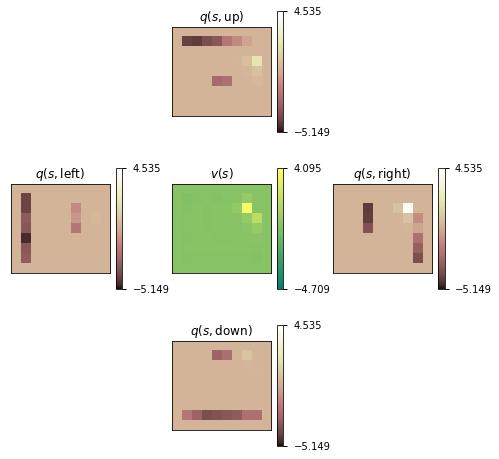

In [ ]:
# Online Q
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

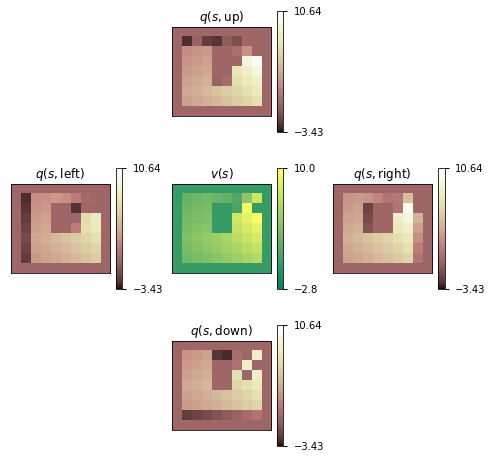

In [ ]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

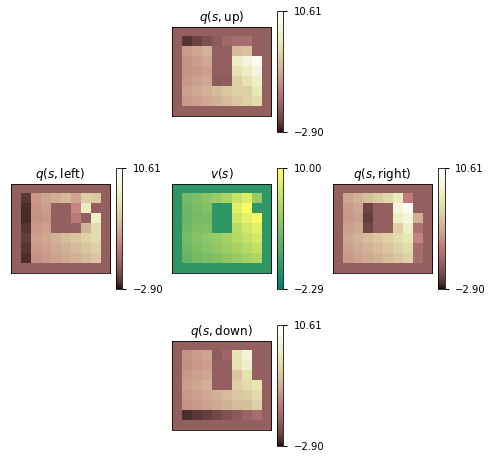

In [ ]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Experiments matching computational cost

*Online Q-learning*

* $\text{number_of_steps}$ = $62,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

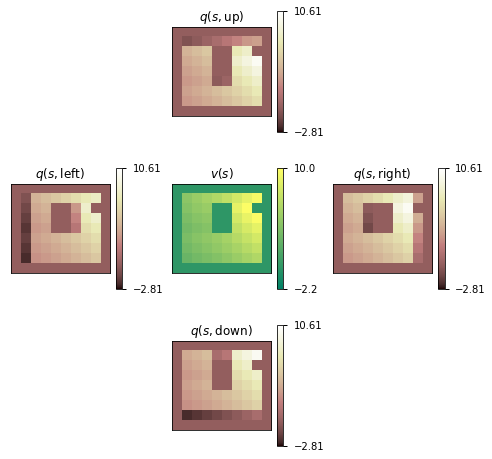

In [ ]:
# OnlineQ
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(62e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

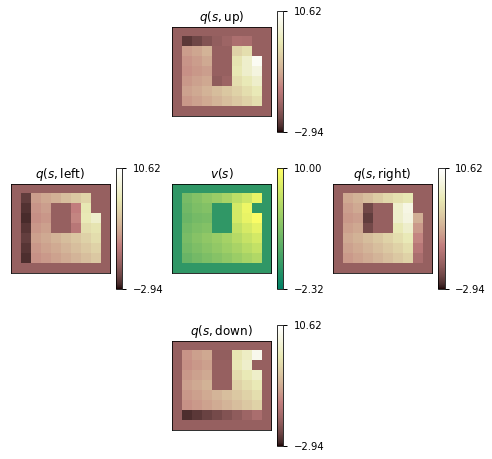

In [ ]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

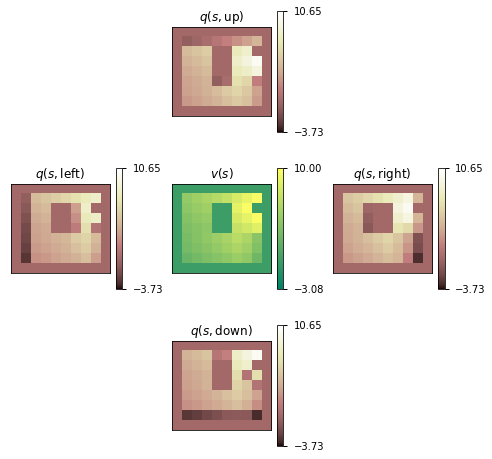

In [ ]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Experiments with linear function approximation

The experiment considers the same 3 algorithms in the context of linear function approximation using the $\text{FeatureGrid}$ domain.

*Online Q-learning*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

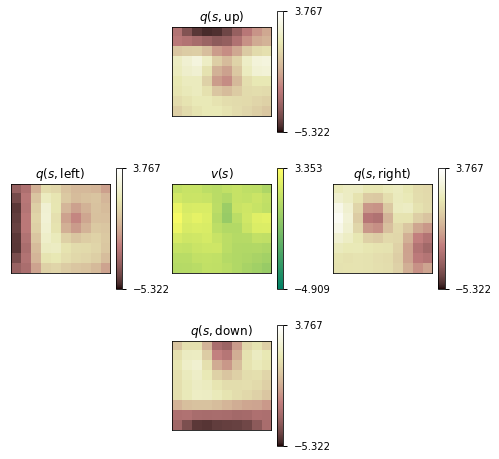

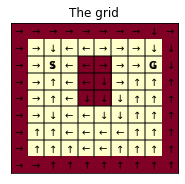

In [ ]:
# OnlineQ
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

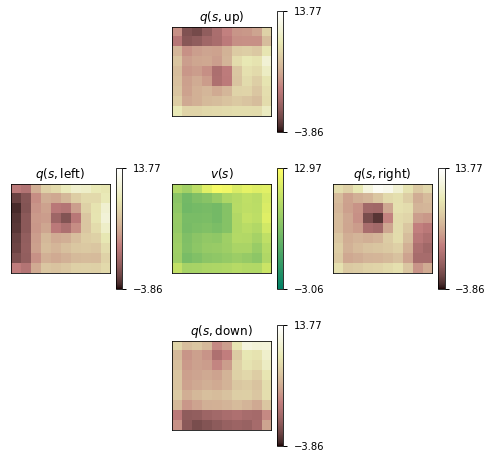

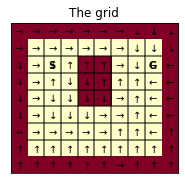

In [ ]:
# Experience Replay
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

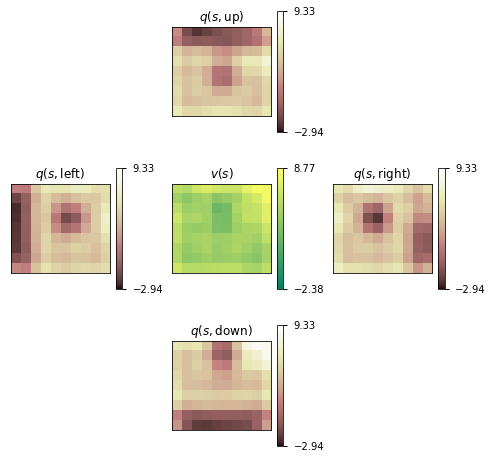

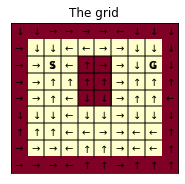

In [ ]:
# LinearDynaQ
grid = FeatureGrid()

agent = LinearDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy)

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

### Experiments with a non-stationary environment

This experiment considers a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left - refer to "Show gridworlds"). The agent is then allowed to continue training for a (shorter) amount of time in this new setting.

*Online Q-learning*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$, and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

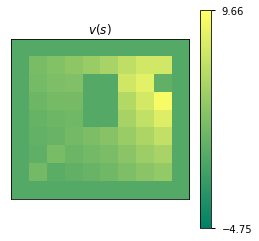

In [ ]:
# Online Q

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

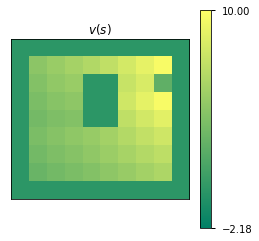

In [ ]:
# Experience Replay

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

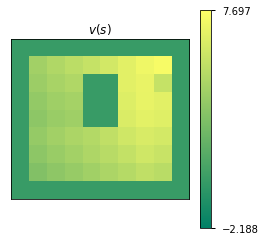

In [ ]:
# DynaQ

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)